In [41]:
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import datetime
import numpy as np
import os

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MAPE

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import TensorBoardLogger


# Config

In [42]:
days_ahead = 1

# Load data

## Timeseries

In [43]:
ts60 = pd.read_csv('../../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)[datetime.datetime(2020, 11, 6):]
ts60.head(3)

,Diff Load Activa Total (60 minuto),Diff Load Primario ACS (60 minuto),Diff Load Consumo ACS (60 minuto),Diff Load Caldera 1 (60 minuto),Diff Load Caldera 2 (60 minuto),True Load Caldera 1 (60 minuto),True Load Caldera 2 (60 minuto),True Load Primario ACS (60 minuto),True Load Consumo ACS (60 minuto),Energía Caldera 1 (60 minuto),...,TEMPERATURA DEPOSITO 2 ACS (60 minuto),DEMANDA CALEFACCIÓN (60 minuto),DEMANDA ACS (60 minuto),DEMANDA QUEMADORES (60 minuto),Caudal Caldera 1 (60 minuto),Caudal Caldera 2 (60 minuto),Caudal Primario ACS (60 minuto),Caudal Consumo ACS (60 minuto),CONTADOR GAS CALDERA 1 (60 minuto),CONTADOR GAS CALDERA 2 (60 minuto)
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-06 00:00:00,2.60,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,38380.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6705.2,12467.6
2020-11-06 01:00:00,2.61,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,38390.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6723.8,12467.6
2020-11-06 02:00:00,2.57,0.02,0.0,0.01,0.0,0.0,0.0,0.0,0.0,38400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6736.1,12467.6


### Choose timeseries variable

In [44]:
tal = pd.DataFrame(ts60['Diff Load Activa Total (60 minuto)'], index=ts60.index)
tal.head()

,Diff Load Activa Total (60 minuto)
datetime,
2020-11-06 00:00:00,2.60
2020-11-06 01:00:00,2.61
2020-11-06 02:00:00,2.57
2020-11-06 03:00:00,2.58
2020-11-06 04:00:00,2.60


## Time features

In [45]:
calendar60 = pd.read_csv('../../VEOLIA/artifacts/time_60min.csv', index_col=1, parse_dates=True)[datetime.datetime(2020, 11, 6):].drop(columns=['Unnamed: 0', 'timestamp'])
calendar60.head(3)

,year,month,day,hour,minute,second,weekday,weekend,holiday
datetime,,,,,,,,,
2020-11-06 00:00:00,2020,11,6,0,0,0,4,False,False
2020-11-06 01:00:00,2020,11,6,1,0,0,4,False,False
2020-11-06 02:00:00,2020,11,6,2,0,0,4,False,False


### Choose subset of time variables
Minutes and seconds are dropped as we have an hourly dataset

In [46]:
time = calendar60.drop(columns=['minute', 'second'])
time.head()

,year,month,day,hour,weekday,weekend,holiday
datetime,,,,,,,
2020-11-06 00:00:00,2020,11,6,0,4,False,False
2020-11-06 01:00:00,2020,11,6,1,4,False,False
2020-11-06 02:00:00,2020,11,6,2,4,False,False
2020-11-06 03:00:00,2020,11,6,3,4,False,False
2020-11-06 04:00:00,2020,11,6,4,4,False,False


## Weather features

In [47]:
weather = pd.read_csv('../../VEOLIA/artifacts/weather_curated_60min.csv', index_col=0, parse_dates=True)[datetime.datetime(2020, 11, 1):]
weather.head(3)

,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id
datetime,,,,,,,,,,,,,
2020-11-01 00:00:00,9.42,9.42,7.63,10.36,1028,99,1.0,140,0.0,0.0,0.0,0,800
2020-11-01 01:00:00,9.96,8.41,7.73,11.47,1028,96,3.1,180,0.0,0.0,0.0,0,800
2020-11-01 02:00:00,10.31,9.93,8.03,11.47,1027,97,5.7,190,0.0,0.0,0.0,0,800


## Create final dataframe after small transformations specific to this problem.

Year and day attributes are dropped as we havent reached that level of seasonality due to few data. Needs update in the future...

In [48]:
data = tal.merge(time, left_index=True, right_index=True).merge(weather, left_index=True, right_index=True)
data.rename(columns={'Diff Load Activa Total (60 minuto)': 'tal'}, inplace=True)
data.drop(columns=['year', 'day'], inplace=True)
data['time_idx'] = data.reset_index().index
# this column if timeseries are given as extra observation in the same dimension of the dataset. this is the label for their discrimination.
data['series'] = 0
data['weekend'] = data['weekend'].astype(str)
data['holiday'] = data['holiday'].astype(str)
data.head()

,tal,month,hour,weekday,weekend,holiday,temp,feels_like,temp_min,temp_max,...,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id,time_idx,series
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-06 00:00:00,2.60,11,0,4,False,False,9.13,6.24,8.69,11.13,...,92,5.7,70,0.0,0.0,0.0,97,500,0,0
2020-11-06 01:00:00,2.61,11,1,4,False,False,10.97,10.19,9.24,11.58,...,79,7.2,130,0.0,0.0,0.0,75,803,1,0
2020-11-06 02:00:00,2.57,11,2,4,False,False,11.09,10.34,10.36,11.48,...,80,7.7,140,0.0,0.2,0.0,0,500,2,0
2020-11-06 03:00:00,2.58,11,3,4,False,False,10.67,9.93,9.24,11.03,...,82,6.2,140,0.0,0.0,0.0,0,800,3,0
2020-11-06 04:00:00,2.60,11,4,4,False,False,11.39,10.65,9.80,11.94,...,79,6.2,130,0.0,0.0,0.0,0,800,4,0


# Training with PyTorch lightning

## Create pytorch-forecasting compatible dataset
This the most important parametrisation to be done. Take care here to set variables to be used, lags, encoders and scalers etc... (See [docs](https://pytorch-forecasting.readthedocs.io/en/latest/data.html))

In [49]:
# context / history lengths
max_context_length = 24*2
min_context_length = 24

# prediction lengths
max_prediction_length = days_ahead * 24
min_prediction_length = 24

# give seasonality prior knowledge here
lags = {"tal": [1, 2, 3, 4, 24, 2*24, 3*24, 7*24]}

# training / validation / test split
training_cutoff = data["time_idx"].max() - max_prediction_length * 2
validation_cutoff = data["time_idx"].max() - max_prediction_length
train_val_data = data[data.time_idx <= validation_cutoff]

# target time series column name
target_timeseries = "tal"
time_varying_unknown_reals = ["tal"]
# time_varying_unknown_reals = ['tal', 'temp', 'feels_like', 'temp_min', 'temp_max',
#                               'pressure', 'humidity', 'wind_speed', 'wind_deg',
#                               'rain_1h', 'rain_3h', 'snow_1h', 'clouds_all', 'weather_id']
time_varying_known_reals = ["holiday", "weekday", "hour", "month"]
time_varying_known_categoricals = ["weekend", "holiday"]
categorical_encoders= {"weekend": NaNLabelEncoder(add_nan=True).fit(train_val_data.weekend),
                       "holiday": NaNLabelEncoder(add_nan=True).fit(train_val_data.holiday)}

training = TimeSeriesDataSet(
    train_val_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target_timeseries,
    categorical_encoders=categorical_encoders,
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=time_varying_unknown_reals,
    # time_varying_known_reals=time_varying_known_reals,
    # time_varying_known_categoricals=time_varying_known_categoricals,
    max_encoder_length=max_context_length,
    min_encoder_length=max_context_length,
    max_prediction_length=max_prediction_length,
    min_prediction_length=max_prediction_length,
    # lags=lags
)

validation = TimeSeriesDataSet.from_dataset(training, train_val_data, min_prediction_idx=training_cutoff + 1)
test = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=validation_cutoff + 1)

## Dataloaders

In [50]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [51]:
# pl.seed_everything(42)
# trainer = pl.Trainer(gpus=1, gradient_clip_val=0.01)
# net = AutoRegressiveBaseModel.from_dataset(training, 
#                                            target="tal"
#                                            target_lags=lags)


## Set model hyperparameters

In [52]:
widths = [256, 512, 1024, 256]
loss = SMAPE()
stack_types = ['generic']
seed = 5
backcast_loss_ratio = 0.5
weight_decay = 0.01

## Locate optimal learning rate

Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:818: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 437 K 
-----------------------------------------------
437 K     Trainable params
0         Non-trainable params
437 K     Total params
1.751     Total estimated model params size (MB)
c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val da

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_MAE': 0.44182586669921875,
 'val_MAPE': 0.2230587750673294,
 'val_MASE': 1.5647488832473755,
 'val_RMSE': 0.5070031881332397,
 'val_SMAPE': 0.2136739045381546,
 'val_backcast_loss': 0.042965006083250046,
 'val_forecast_loss': 0.2136739045381546,
 'val_loss': 0.2136739045381546}
--------------------------------------------------------------------------------


Finding best initial lr:  73%|███████▎  | 73/100 [00:08<00:02,  9.71it/s]c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pytorch_forecasting\models\nbeats\__init__.py:287: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 1, figsize=(6, 8))
Finding best initial lr:  85%|████████▌ | 85/100 [00:09<00:01,  8.35it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_MAE': 0.28955334424972534,
 'val_MAPE': 0.1499883532524109,
 'val_MASE': 1.0254679918289185,
 'val_RMSE': 0.33883336186408997,
 'val_SMAPE': 0.14230486750602722,
 'val_backcast_loss': 0.029311779886484146,
 'val_forecast_loss': 0.14230486750602722,
 'val_loss': 0.14230486750602722}
--------------------------------------------------------------------------------


Finding best initial lr:  99%|█████████▉| 99/100 [00:11<00:00,  8.76it/s]Restoring states from the checkpoint file at c:\Ubuntu\Dev\Windows\I-NERGY\energy-forecasting\lr_find_temp_model.ckpt
Restored all states from the checkpoint file at c:\Ubuntu\Dev\Windows\I-NERGY\energy-forecasting\lr_find_temp_model.ckpt


suggested learning rate: 0.14125375446227537


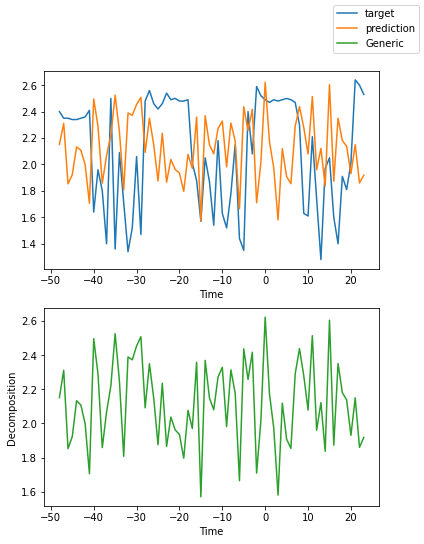

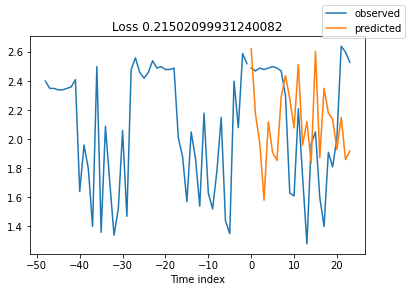

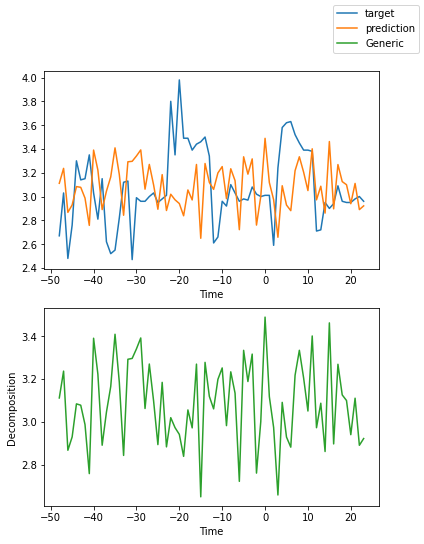

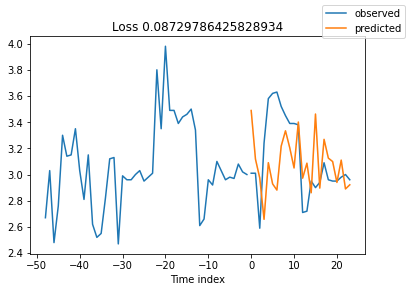

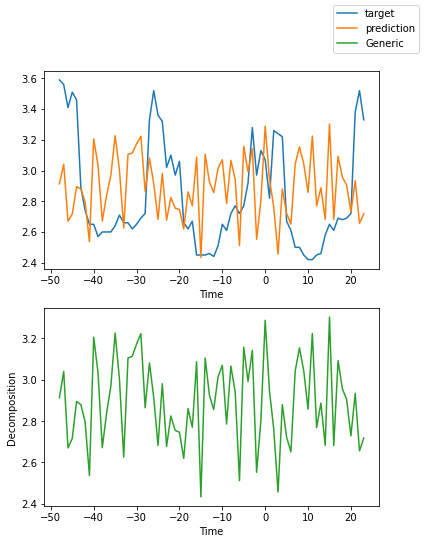

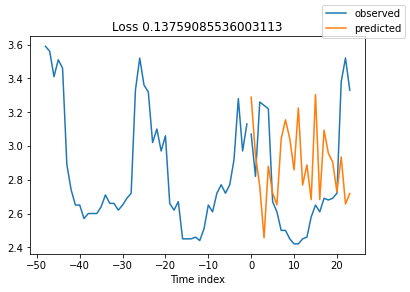

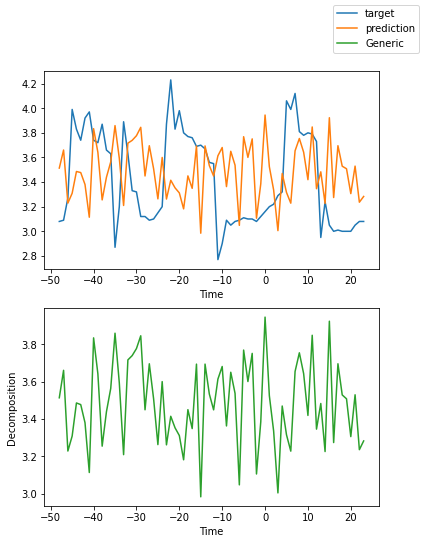

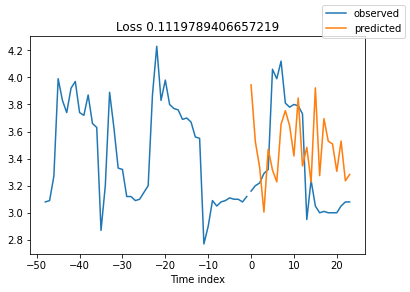

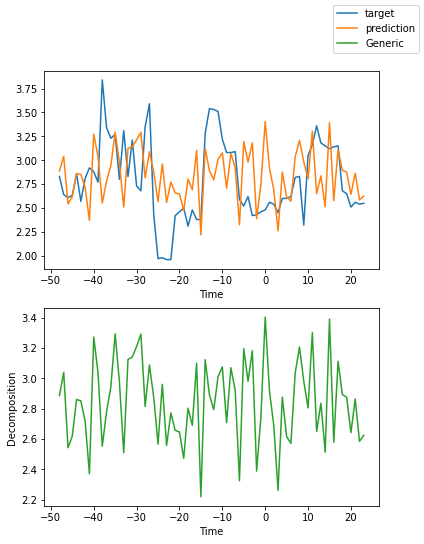

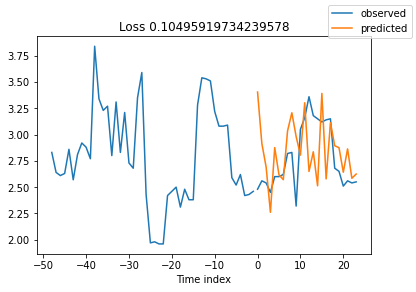

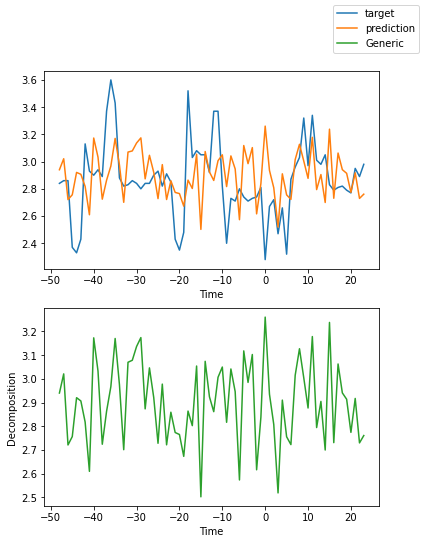

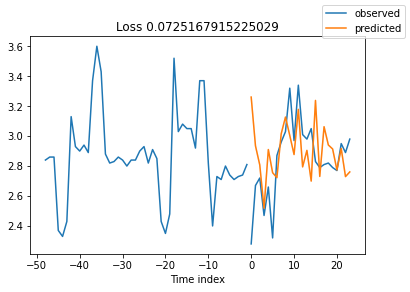

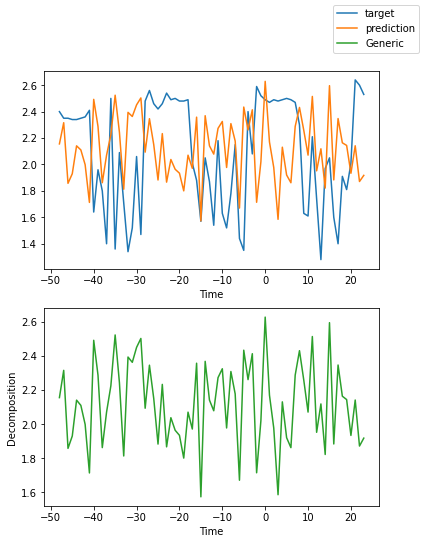

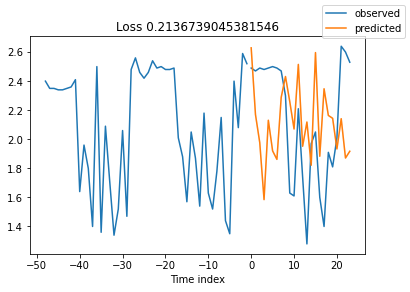

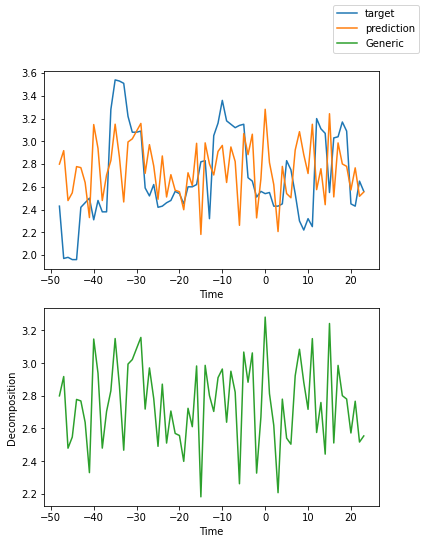

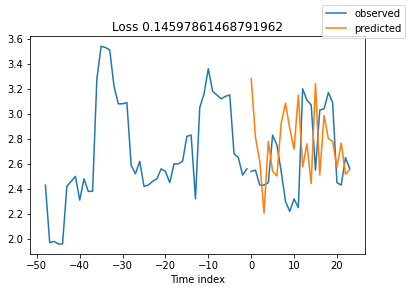

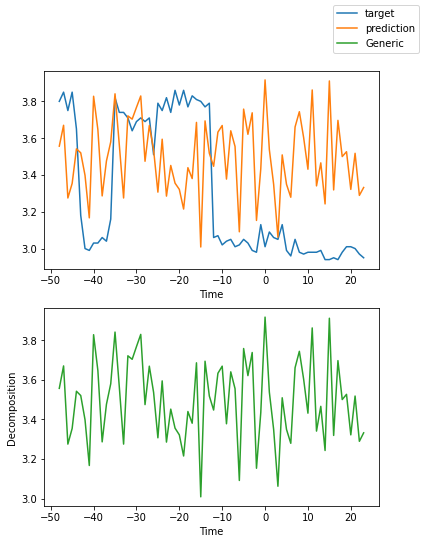

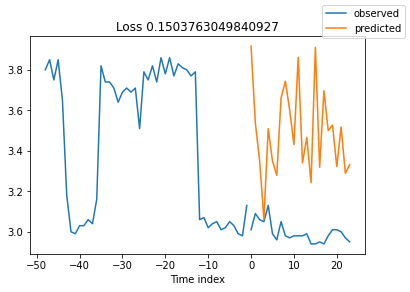

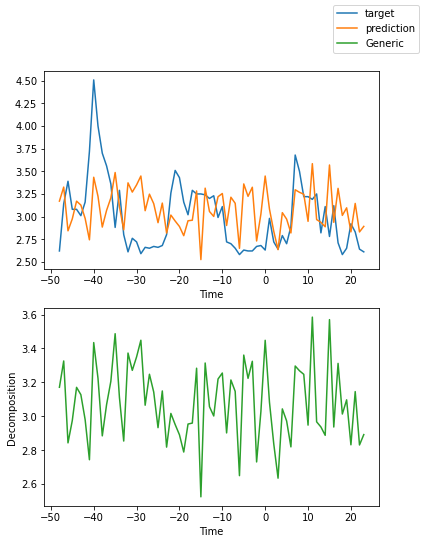

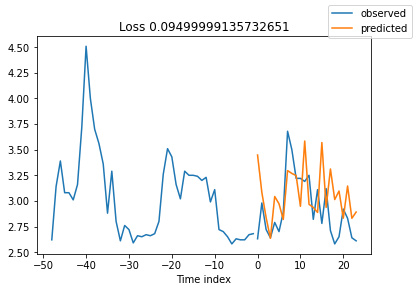

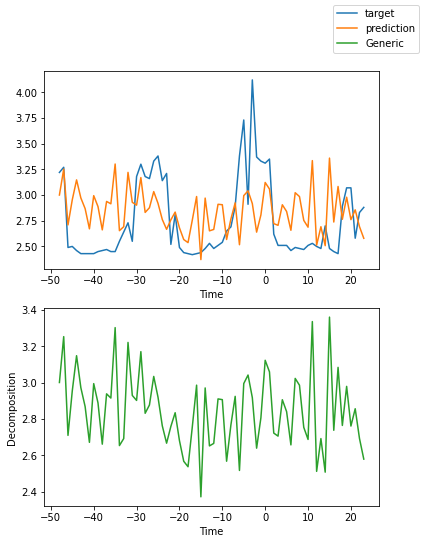

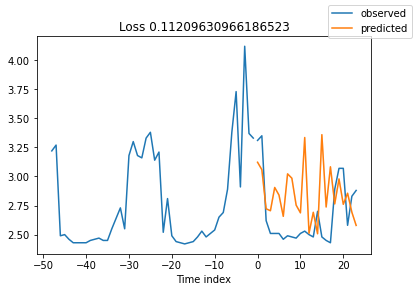

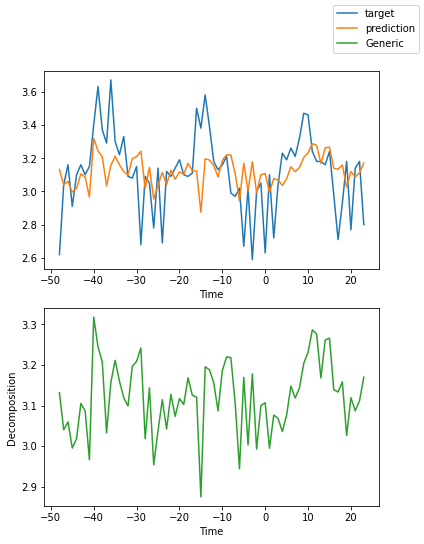

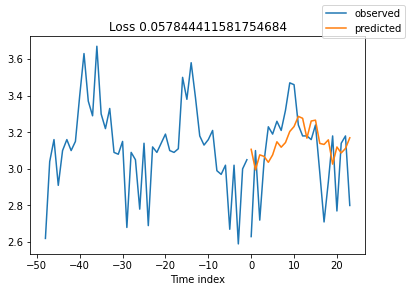

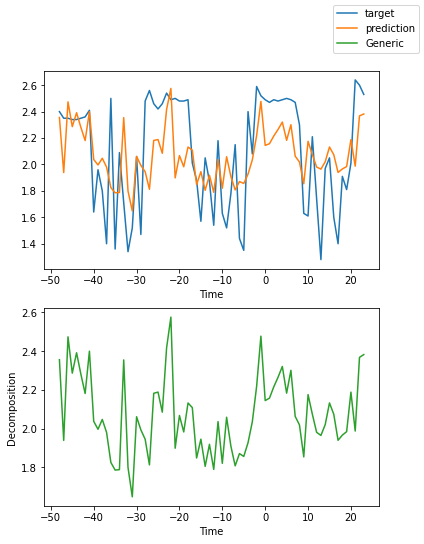

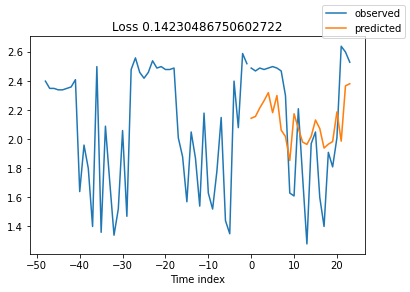

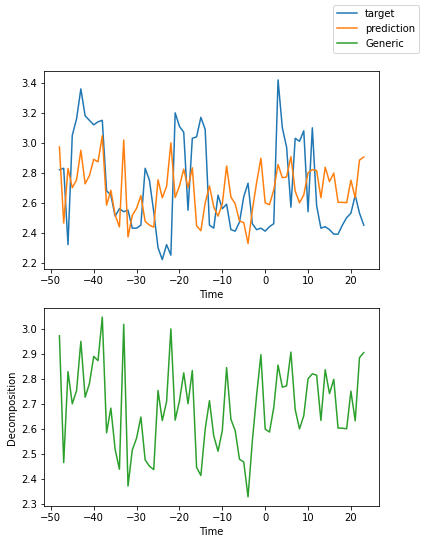

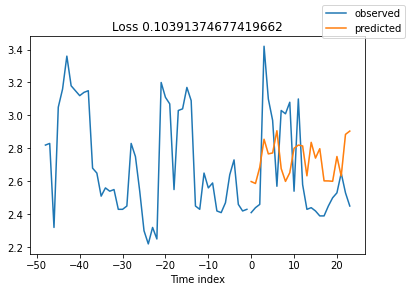

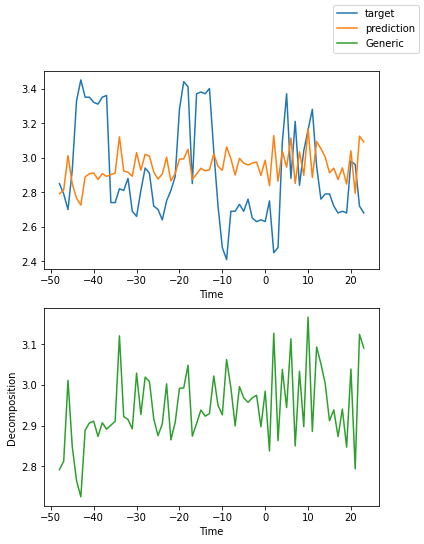

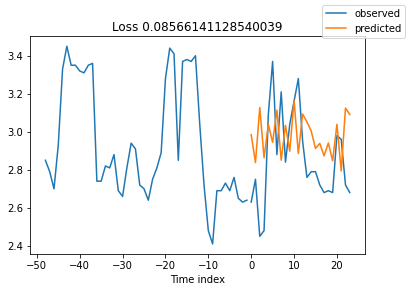

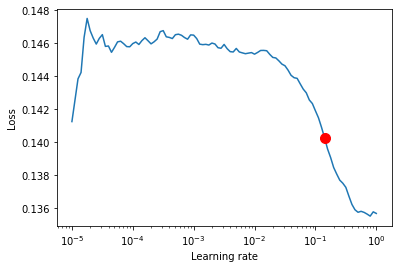

C:\Users\spele\AppData\Local\Temp/ipykernel_33048/4060508587.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [53]:
pl.seed_everything(seed)
trainer = pl.Trainer(gpus=1, gradient_clip_val=0.1)

net = NBeats.from_dataset(
    training,
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    weight_decay=weight_decay,
    widths=widths,
    backcast_loss_ratio=backcast_loss_ratio,
    loss=SMAPE(),
    stack_types=stack_types
)

# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()


## Reinitialise and fit model

In [54]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=20, 
    verbose=False, 
    mode="min")

logger = TensorBoardLogger("../../VEOLIA/models/lightning_logs")

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top", 
    callbacks=[early_stop_callback],
    default_root_dir='../../VEOLIA/models/N-Beats',
    logger=logger
)

net = NBeats.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    weight_decay=weight_decay,
    widths=widths,
    backcast_loss_ratio=backcast_loss_ratio,
    loss=SMAPE(),
    stack_types=stack_types
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 437 K 
-----------------------------------------------
437 K     Trainable params
0         Non-trainable params
437 K     Total params
1.751     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 5
c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:322: UserWarning: The number of training samples (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   0%|          | 0/44 [00:00<00:00, 1001.74it/s]

Finding best initial lr: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


Epoch 27: 100%|██████████| 44/44 [00:05<00:00,  7.72it/s, loss=0.0987, v_num=9, train_loss_step=0.101, val_loss=0.122, train_loss_epoch=0.101]


## Load model

In [55]:
# version = 14
# best_model_path = os.path.join(f'../../VEOLIA/models/N-Beats/lightning_logs/version_{version}/checkpoints/epoch=4-step=2879.ckpt', 
#     os.listdir(f'../../VEOLIA/models/N-Beats/lightning_logs/version_{version}/checkpoints/')[0])
best_model_path = trainer.checkpoint_callback.best_model_path
nbeats = NBeats.load_from_checkpoint(best_model_path)
# nbeats.plot_interpretation()
# nbeats.step()
print(best_model_path)
nbeats.summarize()


c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pytorch_lightning\core\lightning.py:1703: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=1` to replicate `mode=top` behavior.
  rank_zero_deprecation(

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 437 K 
-----------------------------------------------
437 K     Trainable params
0         Non-trainable params
437 K     Total params
1.751     Total estimated model params size (MB)


../VEOLIA/models/lightning_logs\default\version_9\checkpoints\epoch=27-step=1203.ckpt


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 437 K 
-----------------------------------------------
437 K     Trainable params
0         Non-trainable params
437 K     Total params
1.751     Total estimated model params size (MB)

## Predict test set

In [56]:
predictions_test = nbeats.predict(test_dataloader).squeeze()
predictions_val = nbeats.predict(val_dataloader).squeeze()

## Evaluate


TEST SET:

SMAPE naive (torch): 0.1610782891511917
MAPE naive (torch): 0.1610782891511917
MAPE naive (sklearn): 0.1661382537981555
SMAPE (torch): tensor(0.1231)
MAPE (torch): tensor(0.1247)
MAPE(sklearn): 0.12469722140655799
Other metrics:
MSE: 0.09335354567704357
RMSE: 0.3055381247521225


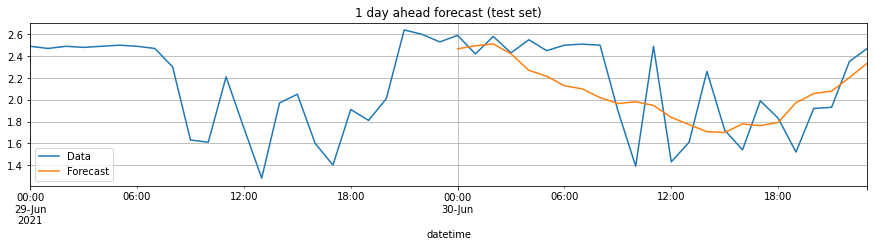


VALIDATION SET:

SMAPE naive (torch): 0.12439370900392532
MAPE naive (torch): 0.12439370900392532
MAPE naive (sklearn): 0.12481892124686488
SMAPE (torch): tensor(0.1222)
MAPE (torch): tensor(0.1233)
MAPE(sklearn): 0.12328902930197277
Other metrics:
MSE: 0.08172382328439524
RMSE: 0.2858737890825167


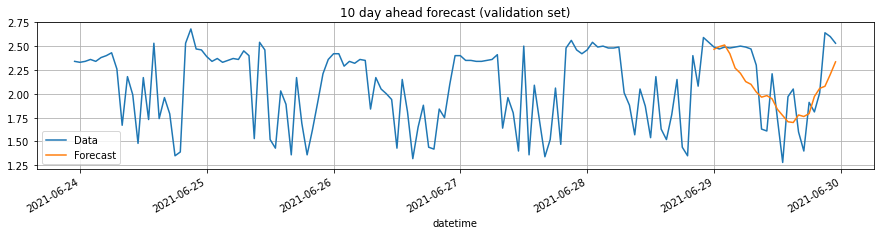

In [57]:
train = train_val_data.iloc[:training_cutoff]["tal"]
val = train_val_data.iloc[training_cutoff + 1 : validation_cutoff + 1]["tal"]
test = data.iloc[validation_cutoff + 1:]["tal"]

print("\nTEST SET:\n")
ground_truth_line = pd.concat((val[-5*24:], test))
naive_pred = [val[-1].tolist()] + test[:-1].tolist()
print(f"SMAPE naive (torch): {SMAPE()(torch.FloatTensor(naive_pred).unsqueeze(1), torch.FloatTensor(test).unsqueeze(1))}")
print(f"MAPE naive (torch): {SMAPE()(torch.FloatTensor(naive_pred).unsqueeze(1), torch.FloatTensor(test).unsqueeze(1))}")
print("MAPE naive (sklearn):", mape(test, naive_pred))

print("======================")
print("SMAPE (torch):", SMAPE()(predictions_test.unsqueeze(1), torch.FloatTensor(test).unsqueeze(1)))
print("MAPE (torch):", MAPE()(predictions_test.unsqueeze(1), torch.FloatTensor(test).unsqueeze(1)))
print("MAPE(sklearn):", mape(test, predictions_test))
print("Other metrics:")
print("MSE:", mse(test, predictions_test))
print("RMSE:", np.sqrt(mse(test, predictions_test)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast (test set)")
pd.Series(predictions_test.numpy(), index=test.index).plot(label='Forecast', legend=True)
plot.grid()
plt.show()

print("\nVALIDATION SET:\n")
ground_truth_line = pd.concat((train[-5*24:], val))
naive_pred = [train[-1].tolist()] + val[:-1].tolist()
print(f"SMAPE naive (torch): {SMAPE()(torch.FloatTensor(naive_pred).unsqueeze(1), torch.FloatTensor(val).unsqueeze(1))}")
print(f"MAPE naive (torch): {SMAPE()(torch.FloatTensor(naive_pred).unsqueeze(1), torch.FloatTensor(val).unsqueeze(1))}")
print("MAPE naive (sklearn):", mape(val, naive_pred))

print("======================")
print("SMAPE (torch):", SMAPE()(predictions_val.unsqueeze(1), torch.FloatTensor(val).unsqueeze(1)))
print("MAPE (torch):", MAPE()(predictions_val.unsqueeze(1), torch.FloatTensor(val).unsqueeze(1)))
print("MAPE(sklearn):", mape(val, predictions_val))
print("Other metrics:")
print("MSE:", mse(val, predictions_val))
print("RMSE:", np.sqrt(mse(val, predictions_val)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title="10 day ahead forecast (validation set)")
pd.Series(predictions_val.numpy(), index=val.index).plot(label='Forecast', legend=True)
plot.grid()
plt.show()